# Data Preparation and Exploration

We are given a dataset containing 15048 GeoTIFF files which contain an RGB image, the corresponding infrared image, the elevation map and a label map that gives each pixel a label from the following classes: <br>
- Impervious surface
- Building
- Low Vegetation
- Tree
- Car
- Clutter/Background 

Our task will be to train some semantic segmentation models that will be able to accurately predict pixel-level labels.

In [1]:
import random
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import matplotlib.pyplot as plt
from utils import read_tiff, plot_tiff, serialize_datapoint, parse_rgb_ir, plot_history, plot_inference_results, build_datasets, parse_rgb, plot_datapoints_from_datasets, parse_datapoint, split_datasets_by_grid, split_train_val, parse_easy, plot_val_and_loss, parse_rgb_ir_augmented, parse_rgb_augmented
from models import build_base_model, build_shallow_unet
from absl import logging
import json
logging.set_verbosity(logging.ERROR)

## Data Selection

In this very brief subsection we analyse the original dataset, select a subset of 5000 images to train, validate and test our models and build 5 folds to perform 5-fold cross validation. 

In [2]:
random.seed(1)

datapoints = [f'data/{element}' for element in os.listdir('data') if element.endswith('.tif')]
print(f'Example Datapoints:\n{datapoints[:3]}\n')
print(f'# of Datapoints: {len(datapoints)}')

n_elements = 5000
selected_datapoints = random.sample(datapoints, n_elements)
random.shuffle(selected_datapoints)
print(f'# of randomly selected Datapoints: {len(selected_datapoints)}\n')

n_folds = 5
fold_size = n_elements // n_folds
folds = [selected_datapoints[i*fold_size: (i+1)*fold_size] for i in range(n_folds)]

# Sanity Check
for i, fold in enumerate(folds):
  print(f'n_datapoints in fold {i} = {len(fold)}')

Example Datapoints:
['data/0000030240-0000043232.tif', 'data/0000016800-0000032256.tif', 'data/0000032704-0000021280.tif']

# of Datapoints: 15048
# of randomly selected Datapoints: 5000

n_datapoints in fold 0 = 1000
n_datapoints in fold 1 = 1000
n_datapoints in fold 2 = 1000
n_datapoints in fold 3 = 1000
n_datapoints in fold 4 = 1000


Here we plot a few of the .tiff images both in RGB, infrared, elevation and segmentation mask.

Filename: data/0000014560-0000038528.tif


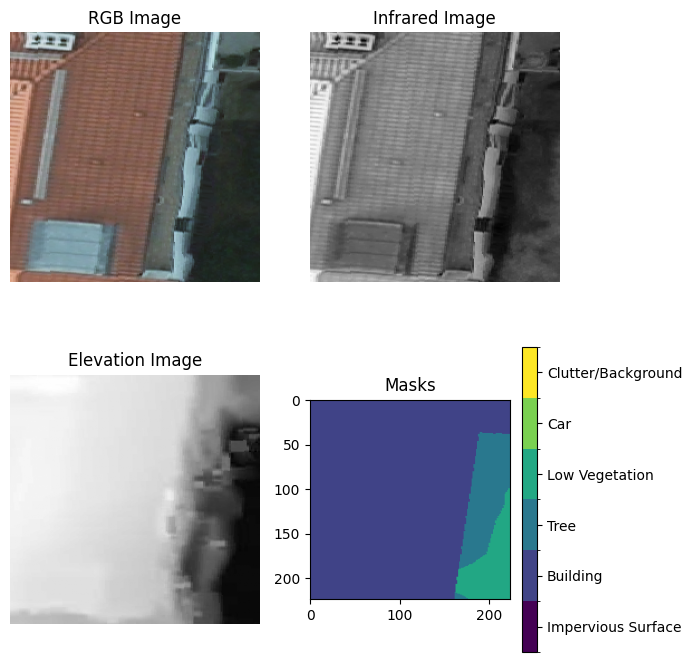

In [3]:
print(f'Filename: {folds[0][5]}')
plot_tiff(folds[0][5], figsize=(7, 7))

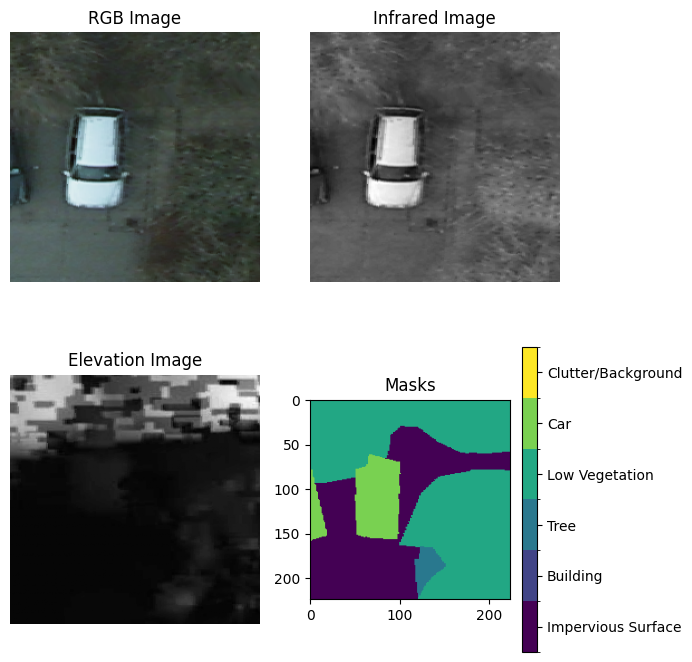

In [4]:
plot_tiff(folds[4][3], figsize=(7, 7))

Next, we build the TFRecord files that will be used during training

In [5]:
from tqdm import tqdm
pbar = tqdm(total=5000)
for i, fold in enumerate(folds):
  with tf.io.TFRecordWriter(f"TFRecord_dir/TFRecord_fold{i}.tfrecord") as writer:
    for datapoint in fold:
        serialized_datapoint = serialize_datapoint(datapoint)
        writer.write(serialized_datapoint)
        pbar.update(1)
pbar.close()

100%|██████████| 5000/5000 [00:49<00:00, 100.23it/s]


# Model Training

### Simple Convolutional Model

We start our analysis by implementing a simple convolutional model with just 2 convolutional layers with kernels of size (3, 3) and 32 and 6 channels respectively.

In [5]:
base_model = build_base_model((224, 224, 4))
base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 6)    │         1,734 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,918 (11.40 KB)

 Trainable params: 2,918 (11.40 KB)

 Non-trainable params: 0 (0.00 B)

We will use the first 3 folds to train, the 4th fold to validate and the 5th fold to test the model. We choose a batch size of 16 and we build the functions _parse\_datapoint_ and _parse\_rgb\_ir_ that respectively parse a datapoint from a TFRecord file and return only its first 4 channels (i.e. RGB + Infrared) and the corresponding labels. <br>
Therefore in this instance we do not exploit the elevation information.

In [4]:
train_filenames = [
    "TFRecord_dir/TFRecord_fold0.tfrecord",
    "TFRecord_dir/TFRecord_fold1.tfrecord",
    "TFRecord_dir/TFRecord_fold2.tfrecord"
]
val_filenames = [
    "TFRecord_dir/TFRecord_fold3.tfrecord"]

test_filenames = [
    "TFRecord_dir/TFRecord_fold4.tfrecord"]

batch_size = 16

epochs = 20

To make the model more robust to rotation and symmetries, we also perform data augmentation during the training phase. <br>
We show an example of how the data might be augmented.

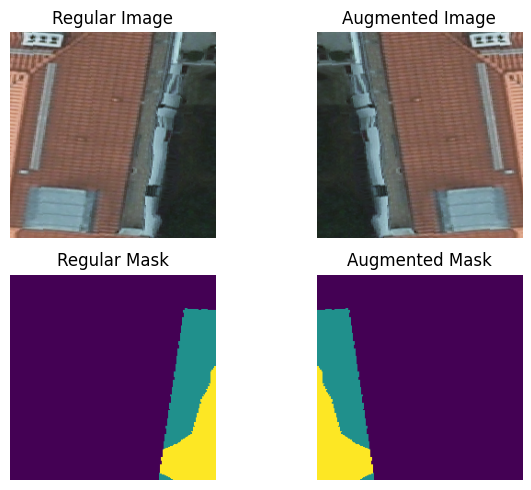

In [7]:
for serialized_datapoint in tf.data.TFRecordDataset('TFRecord_dir/TFRecord_fold0.tfrecord').take(6):
    regular_image, regular_mask = parse_rgb_ir(serialized_datapoint)
    augmented_image, augmented_mask = parse_rgb_ir_augmented(serialized_datapoint)
    
fig, axes = plt.subplots(2, 2, figsize=(7, 5))

axes[0][0].imshow(regular_image[:, :, :3])
axes[0][0].set_title("Regular Image")
axes[0][0].axis("off")

axes[0][1].imshow(augmented_image[:, :, :3])
axes[0][1].set_title("Augmented Image")
axes[0][1].axis("off")

axes[1][0].imshow(np.argmax(regular_mask, axis = -1))
axes[1][0].set_title("Regular Mask")
axes[1][0].axis("off")

axes[1][1].imshow(np.argmax(augmented_mask, axis = -1))
axes[1][1].set_title("Augmented Mask")
axes[1][1].axis("off")

plt.tight_layout()
plt.show()


To build the train dataset we use the .map function to apply the parse_rgb_ir function (which again returns the RGB image and Infrared Image + corresponding label) to the whole training TFRecord file. <br>
We use the _parse\_rgb\_i\r_augmented_ function on the training dataset to do augmentation, and the regular parsing function in the validation and test.
We choose 100 as buffer_size to limit the use of RAM and we choose a batch size of 16. <br>
The number of epochs is 20 because we do not have enough computational power to perform a longer training.

In [8]:
train_dataset, val_dataset, test_dataset = build_datasets(train_filenames,
                                                          val_filenames,
                                                          test_filenames,
                                                          parse_rgb_ir_augmented, 
                                                          parse_rgb_ir)

checkpoint = ModelCheckpoint(
    filepath='best_base_model.keras',  
    monitor='val_loss',           
    save_best_only=True,          
    mode='min',                   
    verbose=1    
)

We show the code that we use for the training.

In [ ]:
steps_per_epoch = 3000 // batch_size 
history = base_model.fit(train_dataset,
                        epochs=epochs,
                        steps_per_epoch = steps_per_epoch,
                        validation_data=val_dataset, 
                        callbacks = [checkpoint])

We performed the training on Colab with a T4 GPU and obtained the following trained model and the following history.

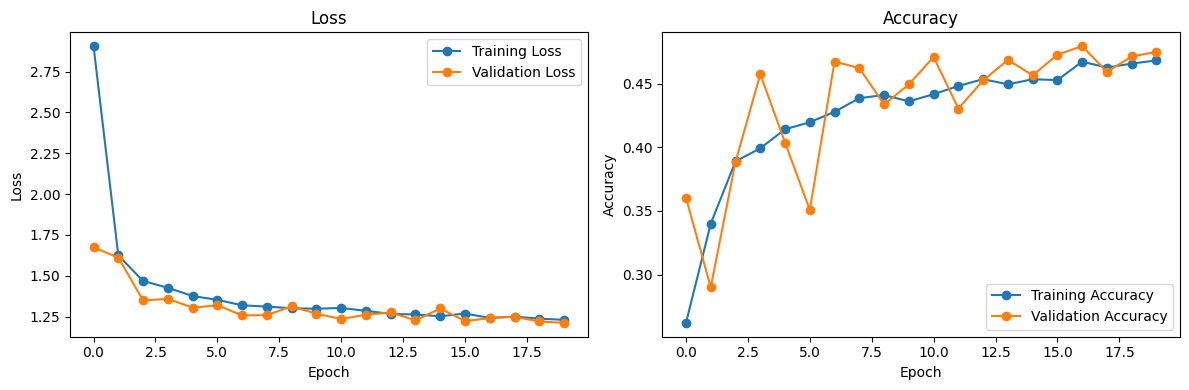

In [9]:
base_model = tf.keras.models.load_model('saved_models/base_model_aug.keras')
base_history = plot_history('saved_models/history_base_aug.json')

In [10]:
print(f'Best Validation Accuracy: {np.max(base_history["val_accuracy"]):.3f}\nFinal Validation Accuracy: {base_history["val_accuracy"][-1]:.3f}')

Best Validation Accuracy: 0.479
Final Validation Accuracy: 0.475


Next, we evaluate the model performance on the test set.

In [19]:
test_loss, test_accuracy = base_model.evaluate(test_dataset, steps=1000//batch_size)
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.4824 - loss: 1.2034
Test Loss: 1.204
Test Accuracy: 0.487


We now plot some of the inference results against their ground truths

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


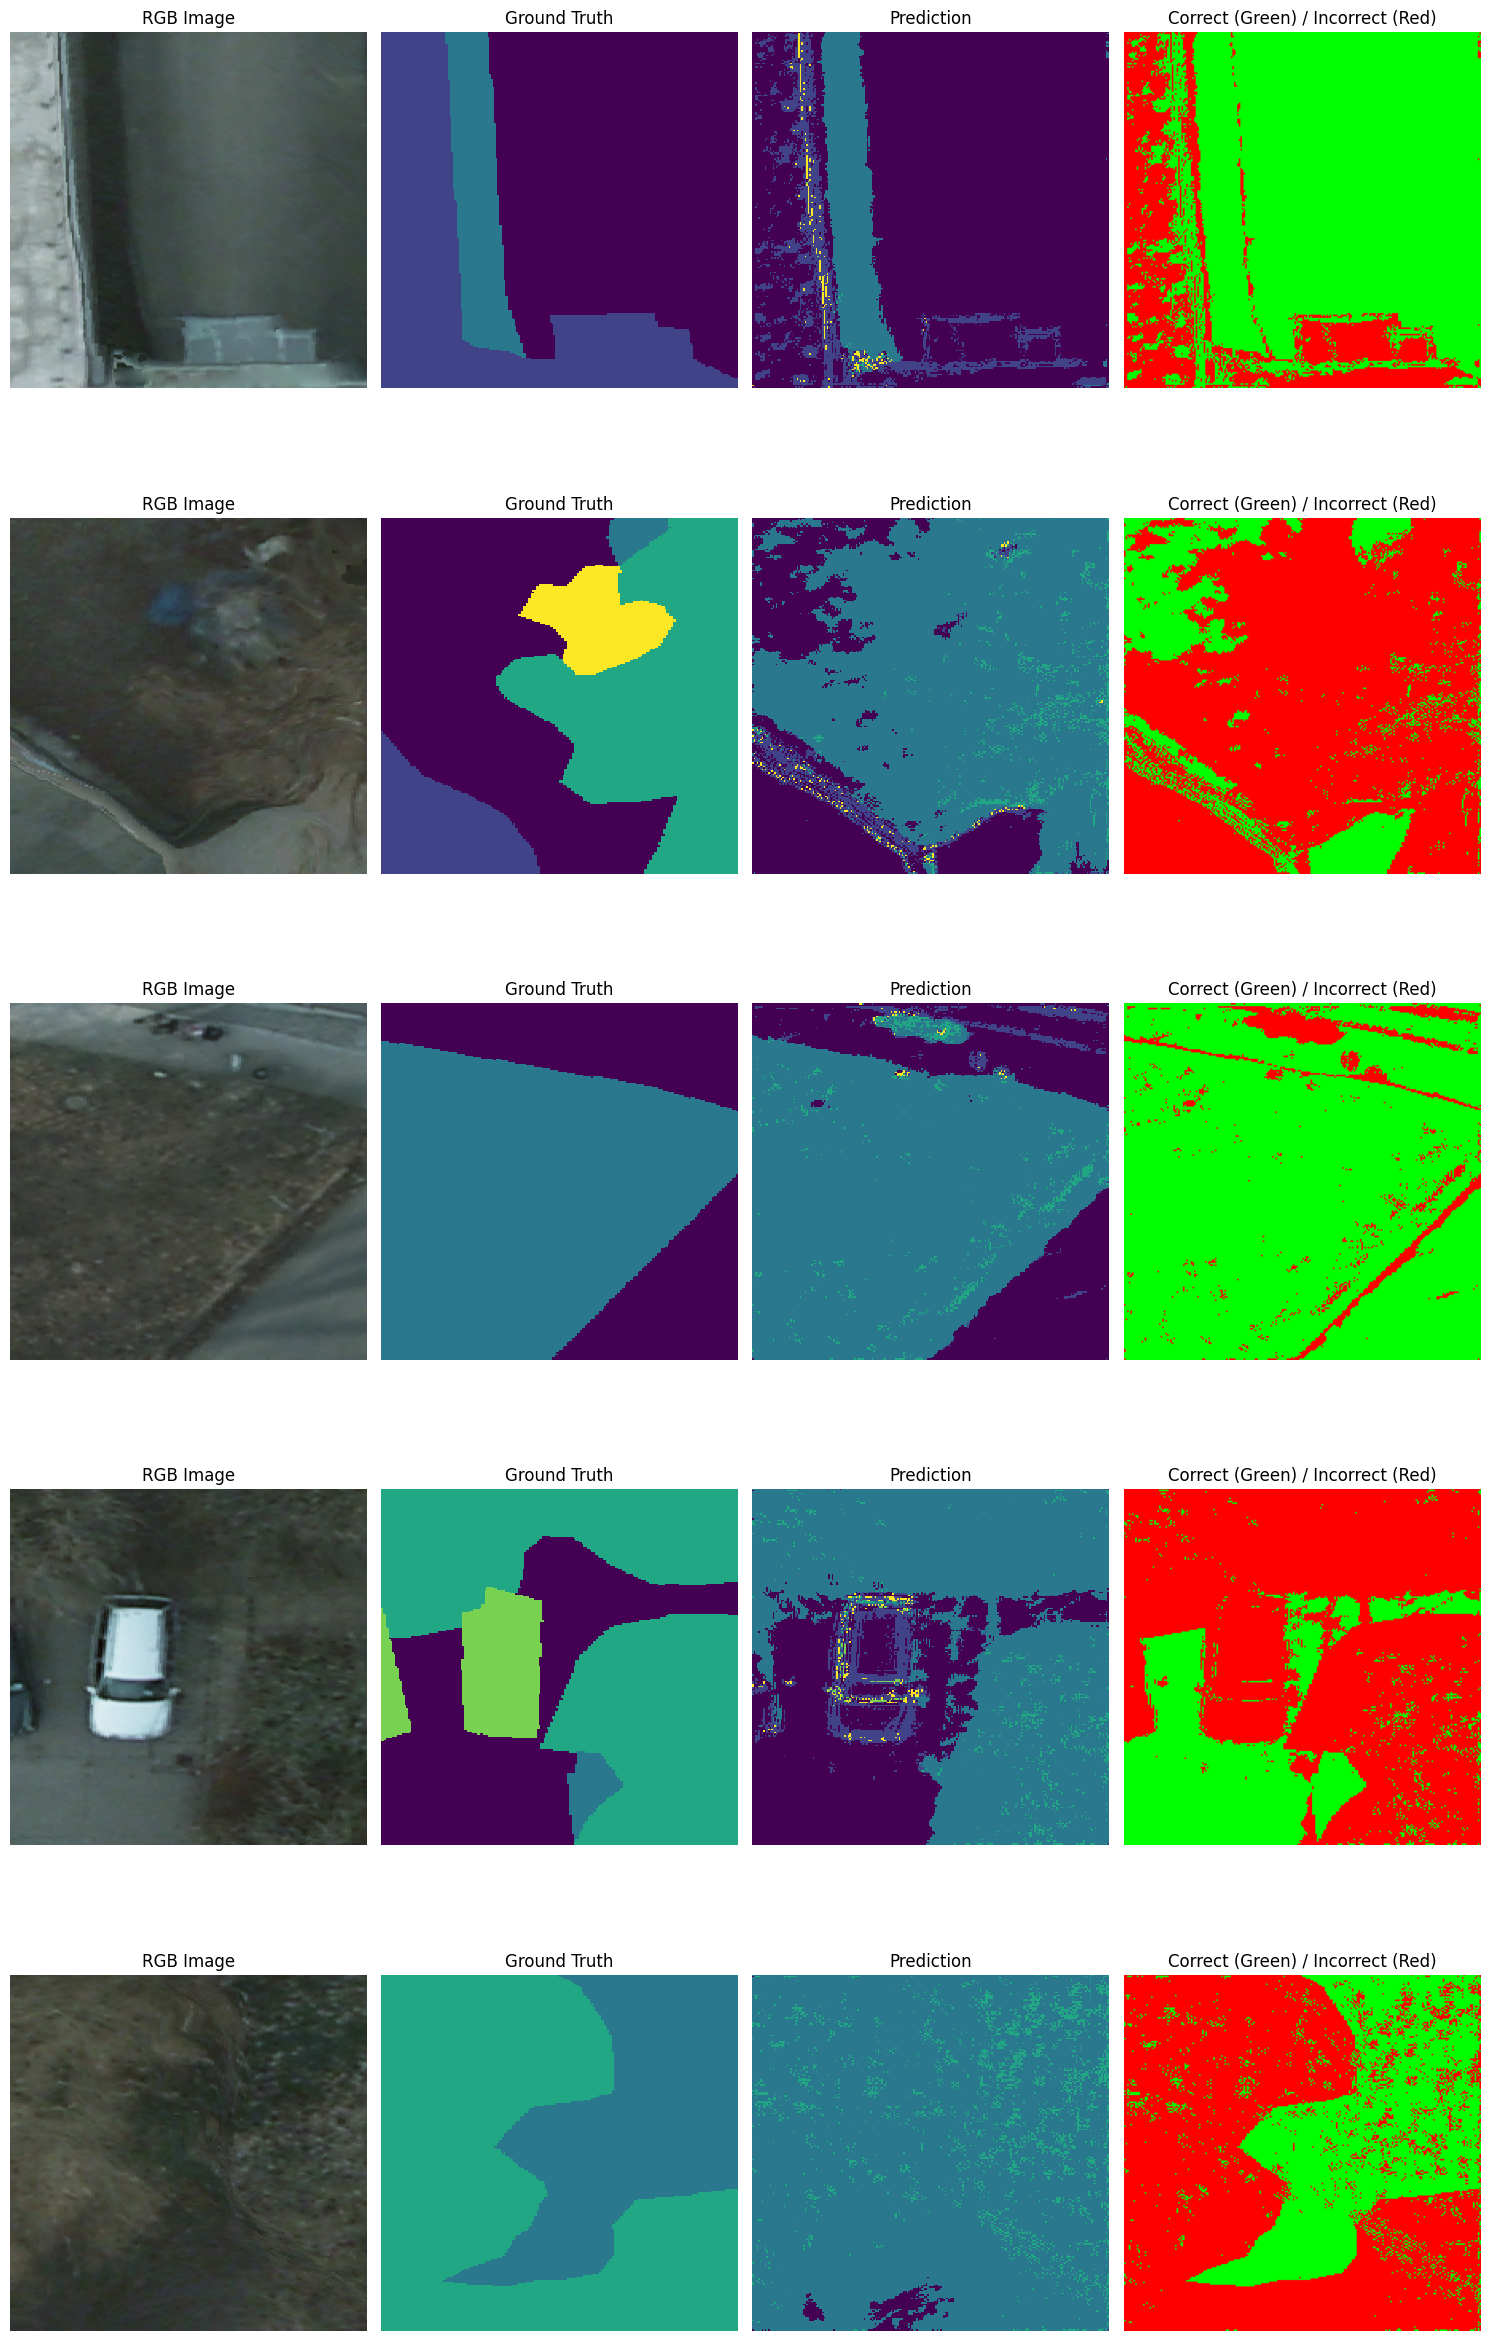

In [12]:
plot_inference_results(test_dataset, base_model, 5)

As we can see, the model is able to detect some structure, but is very imprecise and consistently mislabels the pixels.

### Shallow U-Net Model

To improve the performance on the task, we implement a shallow version of the famous U-Net architecture.

In [6]:
train_dataset, val_dataset, test_dataset = build_datasets(train_filenames,
                                                          val_filenames,
                                                          test_filenames,
                                                          parse_rgb_augmented, 
                                                          parse_rgb)

unet_model = build_shallow_unet((224, 224, 5))
unet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 224, 224,  │      1,472 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 112, 112,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 56, 56,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 112, 112,  │     36,928 │ conv2d_6[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 112, 112,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 224, 224,  │     36,896 │ concatenate_2[0]… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 224, 224,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 224, 224,  │     18,464 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 224, 224,  │      1,734 │ conv2d_transpose… │
│                     │ 6)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 150,918 (589.52 KB)

 Trainable params: 150,918 (589.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20
steps_per_epoch = 3000 // batch_size
history = unet_model.fit(train_dataset, 
                    epochs=epochs, 
                    steps_per_epoch = steps_per_epoch,
                    validation_data=val_dataset, 
                    callbacks = [checkpoint])

Once again, we perform the training on Colab with a T4 GPU and obtain the following model and history.

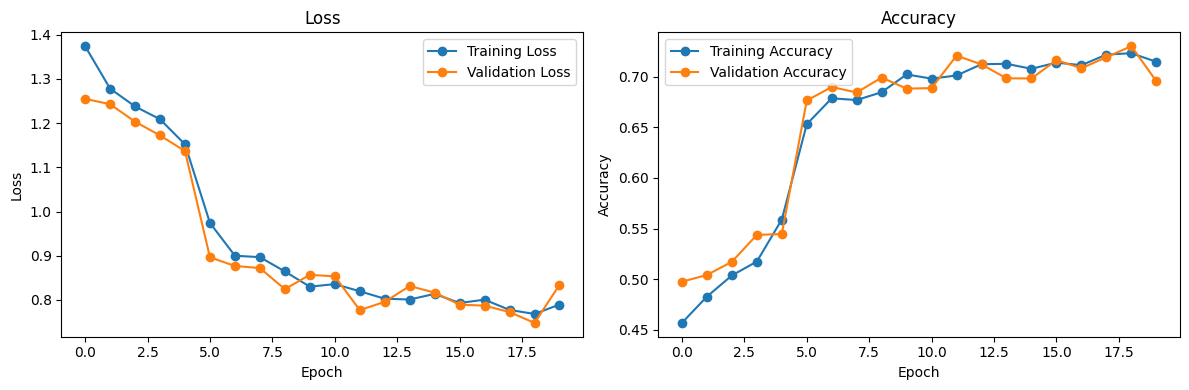

In [14]:
unet_model = tf.keras.models.load_model('saved_models/unet_model_aug.keras')
unet_history = plot_history('saved_models/history_unet.json')

In [15]:
print(f'Best Validation Accuracy: {np.max(unet_history["val_accuracy"]):.3f}\nFinal Validation Accuracy: {unet_history["val_accuracy"][-1]:.3f}')

Best Validation Accuracy: 0.730
Final Validation Accuracy: 0.696


In [15]:
test_loss, test_accuracy = unet_model.evaluate(test_dataset, steps=1000//batch_size)
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')

62/62 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7435 - loss: 0.7206
Test Loss: 0.720
Test Accuracy: 0.744


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


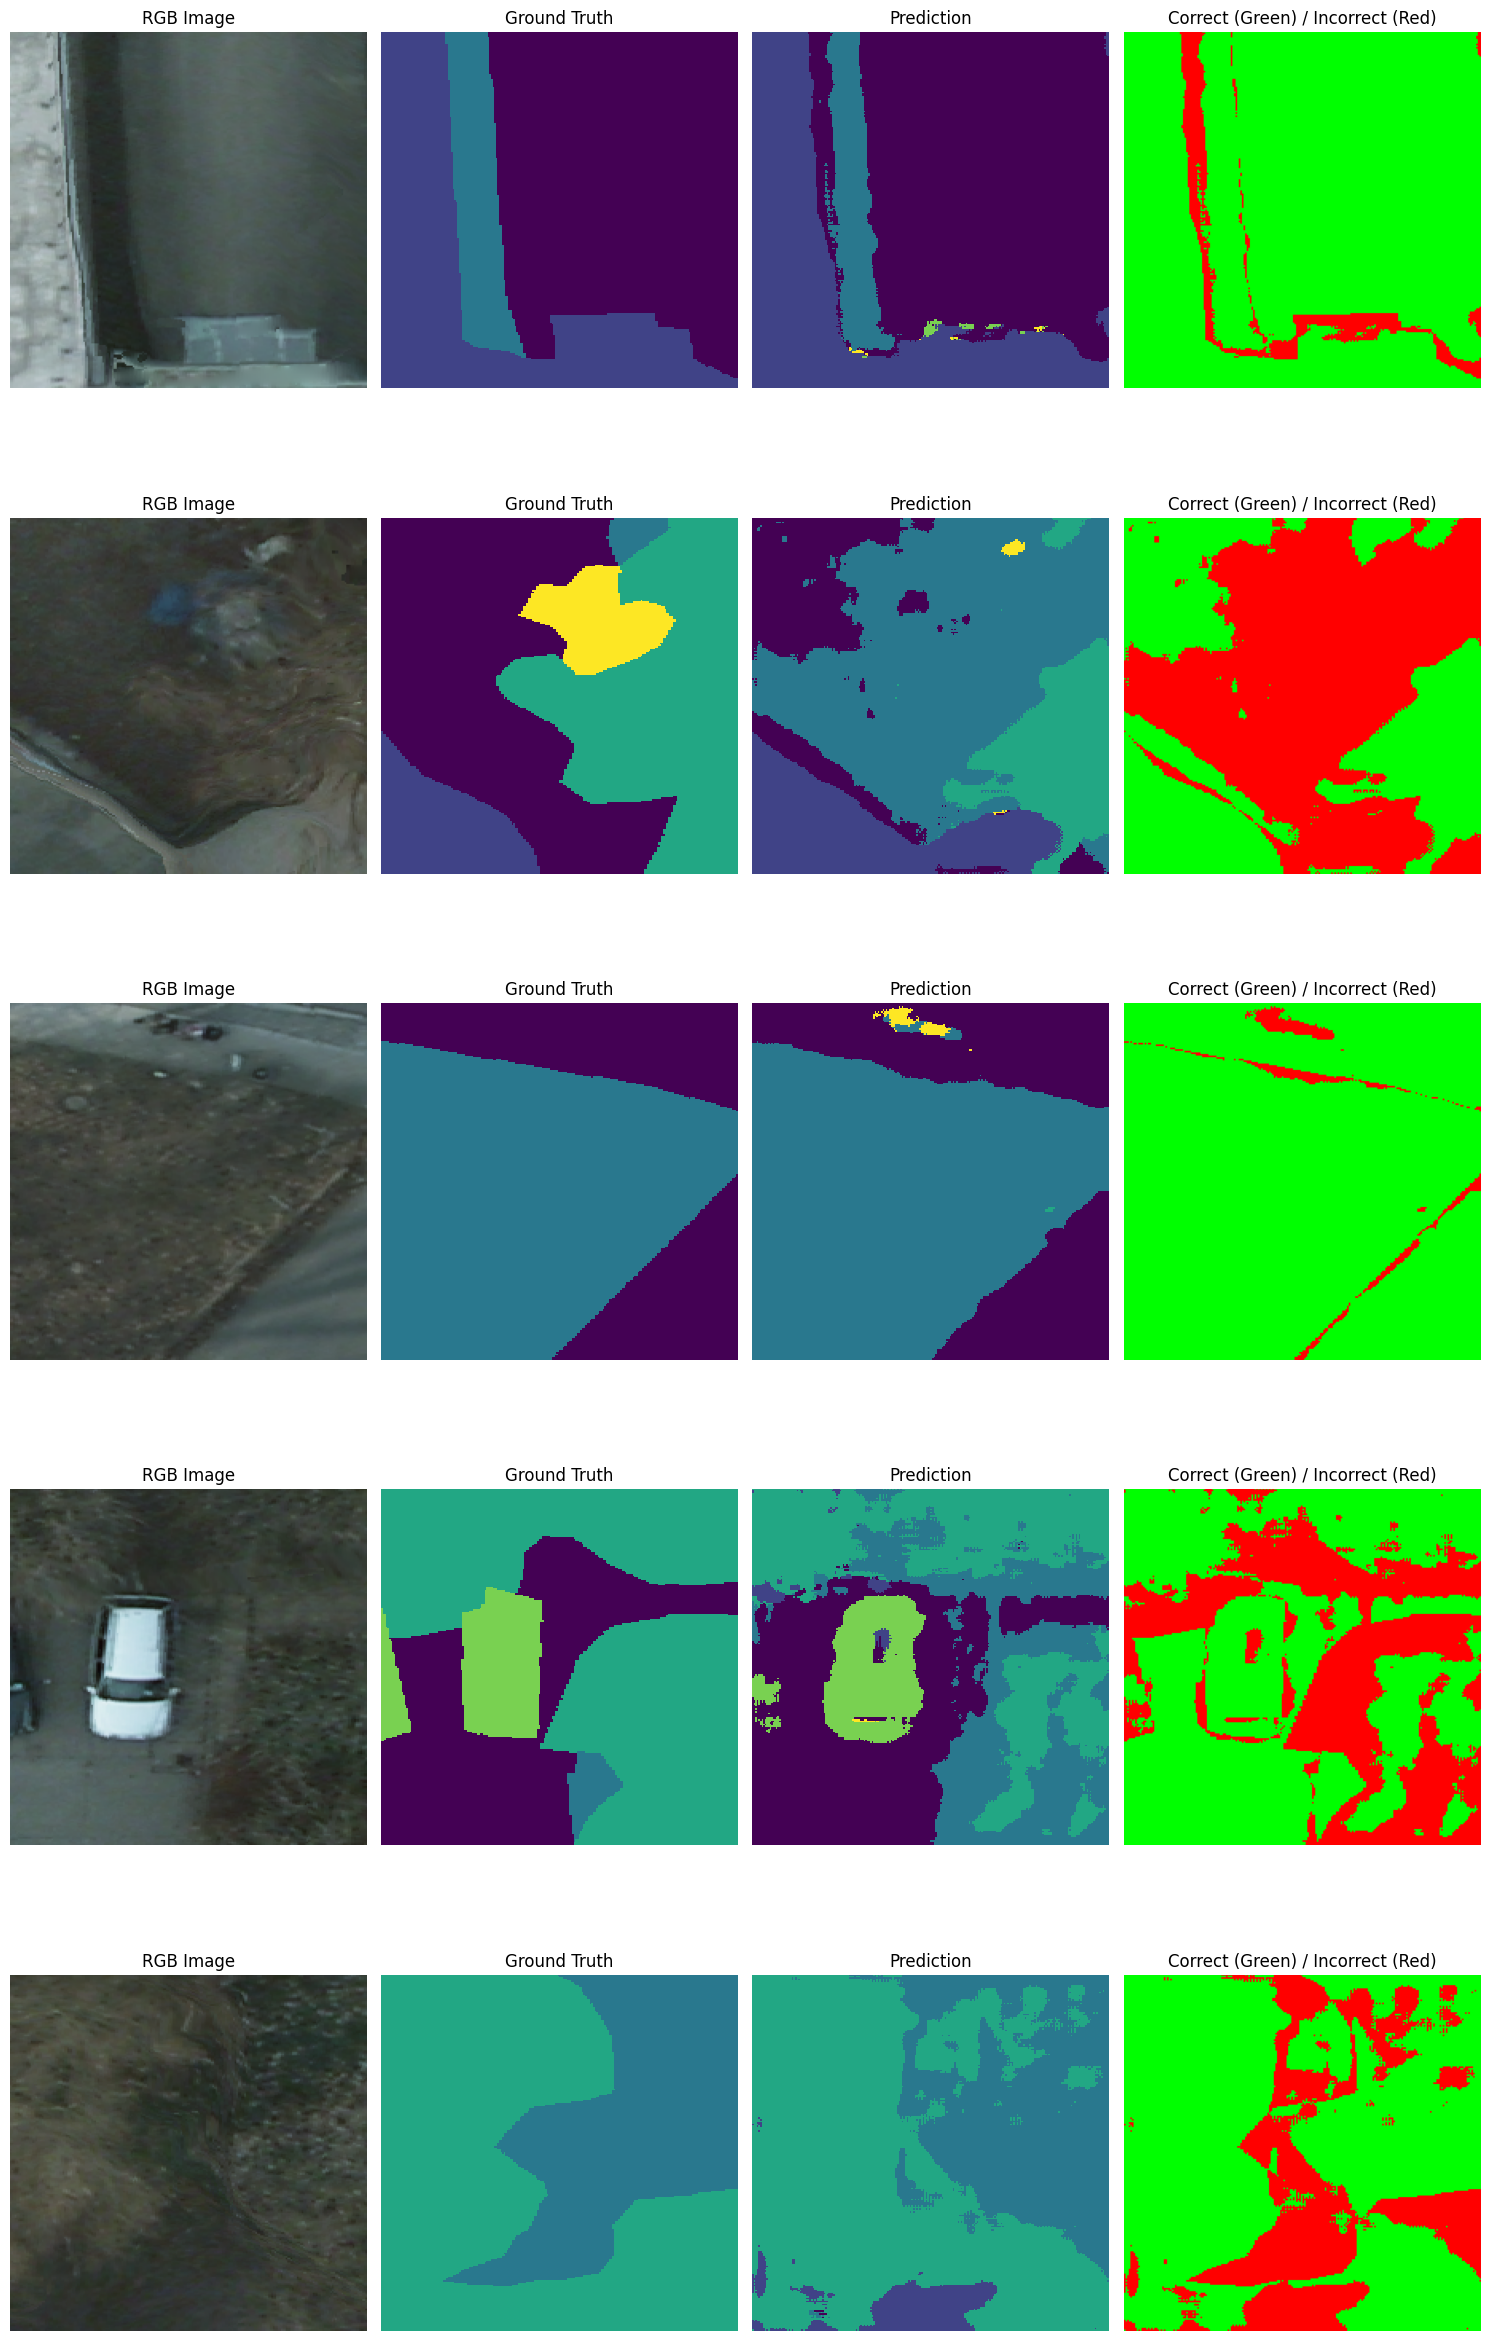

In [16]:
plot_inference_results(test_dataset, unet_model, 5)

This time, we notice that the model performs much better and makes much finer predictions. We can see for instance that cars now seem to be labelled correctly by the model, whereas this was not the case with the previous model.

# New Train/Val/Test Split Method

In this section, we implement a different approach to train/val/test splitting, following some ideas expressed in the paper: _'A Generalizable and Accessible Approach to Machine Learning with Global Satellite Imagery'_ by Rolf et al. (2021).

In our first approach, we simply split the data into 3 training folds, 1 validation fold and 1 test fold. If we visualize the data in longitude/latitude space we obtain the following result.

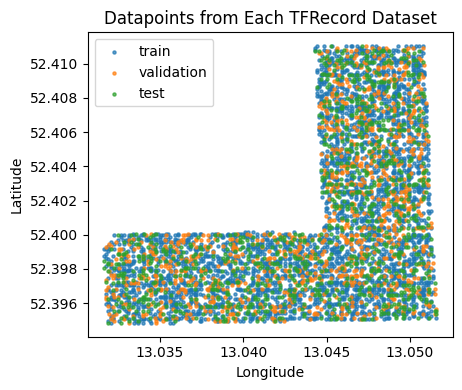

In [16]:
train = tf.data.TFRecordDataset(["TFRecord_dir/TFRecord_fold0.tfrecord",
                                 "TFRecord_dir/TFRecord_fold1.tfrecord",
                                 "TFRecord_dir/TFRecord_fold2.tfrecord"]).map(parse_datapoint)
val = tf.data.TFRecordDataset("TFRecord_dir/TFRecord_fold3.tfrecord").map(parse_datapoint)
test = tf.data.TFRecordDataset("TFRecord_dir/TFRecord_fold4.tfrecord").map(parse_datapoint)

plot_datapoints_from_datasets([train, val, test], figsize = (5, 4), labels=['train', 'validation', 'test'])

As we can see, the points were evely distributed in the space, and at least in the latitude/longitude space both the validation and test datasets were close to the training dataset. <br>
Now we try to implement the approach suggested in the paper, partitioning the latitude and longitude space into a grid according to some angles, then training on some grid cells and validating on others.

In [17]:
data = tf.data.TFRecordDataset(["TFRecord_dir/TFRecord_fold0.tfrecord",
                                 "TFRecord_dir/TFRecord_fold1.tfrecord",
                                 "TFRecord_dir/TFRecord_fold2.tfrecord",
                                 "TFRecord_dir/TFRecord_fold3.tfrecord",
                                 "TFRecord_dir/TFRecord_fold4.tfrecord"]).map(parse_datapoint)

The code that we will use to train is once again the following. The trainings are done on Colab with a T4 GPU.

In [ ]:
checkpoint = ModelCheckpoint(
    filepath='model.keras',  
    monitor='val_loss',           
    save_best_only=True,          
    mode='min',                   
    verbose=1    
)
batch_size = 16
epochs = 20
history = unet_model.fit(train_dataset,
                        epochs=epochs,
                        validation_data=val_dataset, 
                        callbacks = [checkpoint])

## $\delta = 0.0005$

In [18]:
train, test = split_datasets_by_grid([data], grid_size=0.0005)
train, val = split_train_val(train, split_ratio=0.8)
train_dataset, val_dataset, test_dataset = build_datasets(train, val, test, parse_easy, parse_easy)

Train and Test Data Distribution:



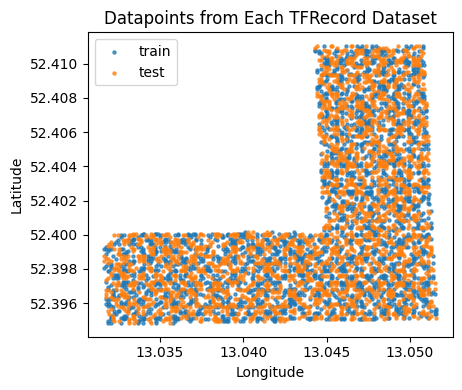

TRAINING HISTORY



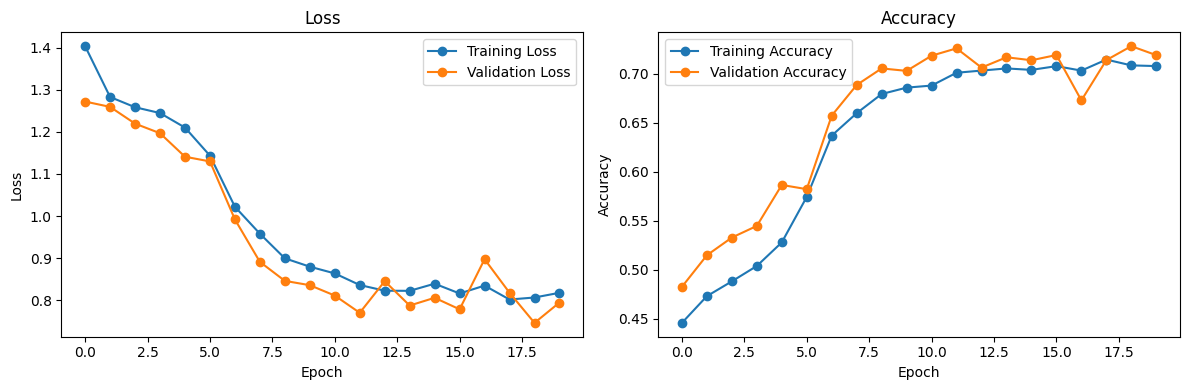

160/160 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.7147 - loss: 0.7826
Test Loss: 0.791
Test Accuracy: 0.712


/Users/alessandroardenghi/anaconda3/envs/kmeans/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [19]:
train, test = split_datasets_by_grid([data], grid_size=0.0005)
print('Train and Test Data Distribution:\n')
plot_datapoints_from_datasets([train, test], figsize = (5, 4), labels=['train', 'test'])
train, val = split_train_val(train, split_ratio=0.8)
train_dataset, val_dataset, test_dataset = build_datasets(train, val, test, parse_easy, parse_easy)

model_0005 = tf.keras.models.load_model('saved_models/best_model_0005.keras')
print('TRAINING HISTORY\n')
history = plot_history('saved_models/history_0005.json')

test_loss_0005, test_accuracy_0005 = model_0005.evaluate(test_dataset)
print(f'Test Loss: {test_loss_0005:.3f}')
print(f'Test Accuracy: {test_accuracy_0005:.3f}')

Train and Test Data Distribution:



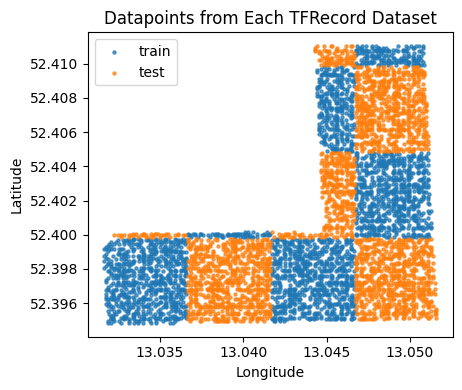

TRAINING HISTORY



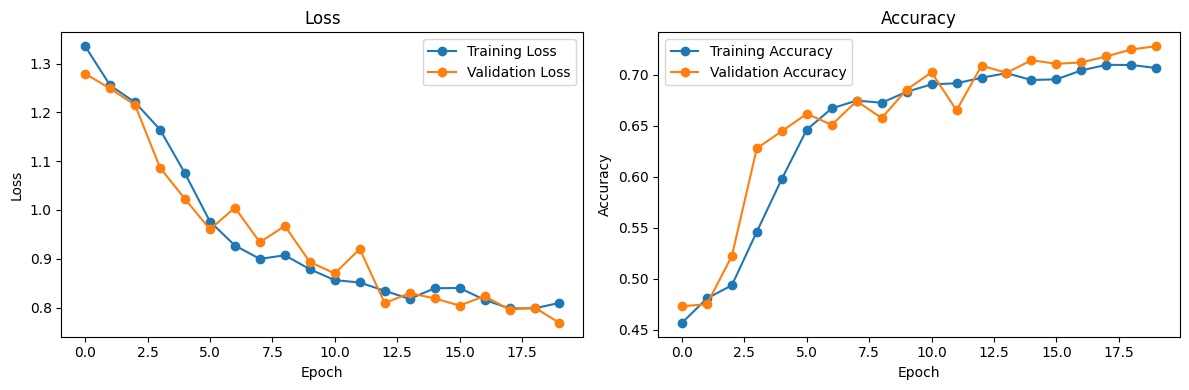

160/160 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.7258 - loss: 0.7818
Test Loss: 0.765
Test Accuracy: 0.732


/Users/alessandroardenghi/anaconda3/envs/kmeans/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [20]:
train, test = split_datasets_by_grid([data], grid_size=0.005)
print('Train and Test Data Distribution:\n')
plot_datapoints_from_datasets([train, test], figsize = (5, 4), labels=['train', 'test'])
train, val = split_train_val(train, split_ratio=0.8)
train_dataset, val_dataset, test_dataset = build_datasets(train, val, test, parse_easy, parse_easy)

model_005 = tf.keras.models.load_model('saved_models/best_model_005.keras')
print('TRAINING HISTORY\n')
history = plot_history('saved_models/history_005.json')

test_loss_005, test_accuracy_005 = model_005.evaluate(test_dataset, steps=160)
print(f'Test Loss: {test_loss_005:.3f}')
print(f'Test Accuracy: {test_accuracy_005:.3f}')

Train and Test Data Distribution:



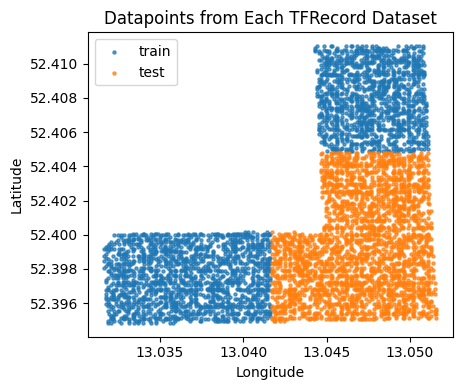

TRAINING HISTORY



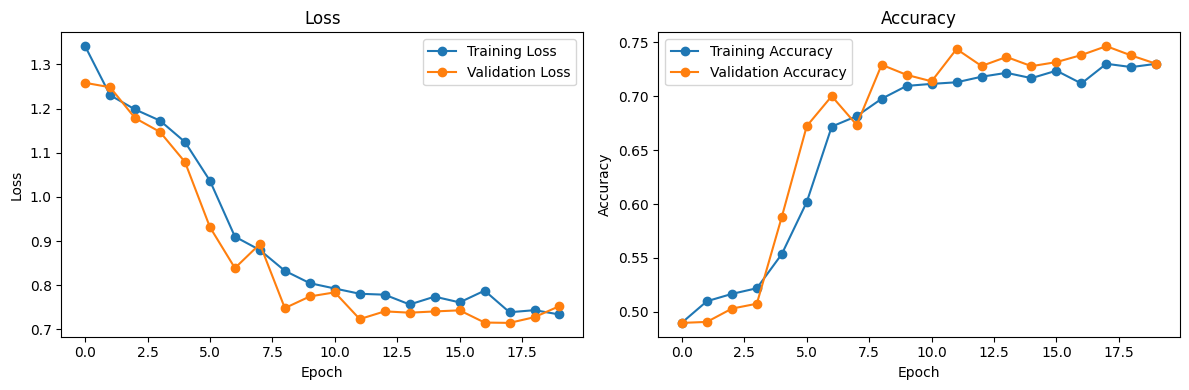

159/159 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.6958 - loss: 1.0119
Test Loss: 0.982
Test Accuracy: 0.702


In [21]:
train, test = split_datasets_by_grid([data], grid_size=0.01)
print('Train and Test Data Distribution:\n')
plot_datapoints_from_datasets([train, test], figsize = (5, 4), labels=['train', 'test'])
train, val = split_train_val(train, split_ratio=0.8)
train_dataset, val_dataset, test_dataset = build_datasets(train, val, test, parse_easy, parse_easy)

model_01 = tf.keras.models.load_model('saved_models/best_model_01.keras')
print('TRAINING HISTORY\n')
history = plot_history('saved_models/history_01.json')

test_loss_01, test_accuracy_01 = model_01.evaluate(test_dataset, steps=159)
print(f'Test Loss: {test_loss_01:.3f}')
print(f'Test Accuracy: {test_accuracy_01:.3f}')


Next, we compare the results of the validation and test accuracies while incraesing the value of $\delta$

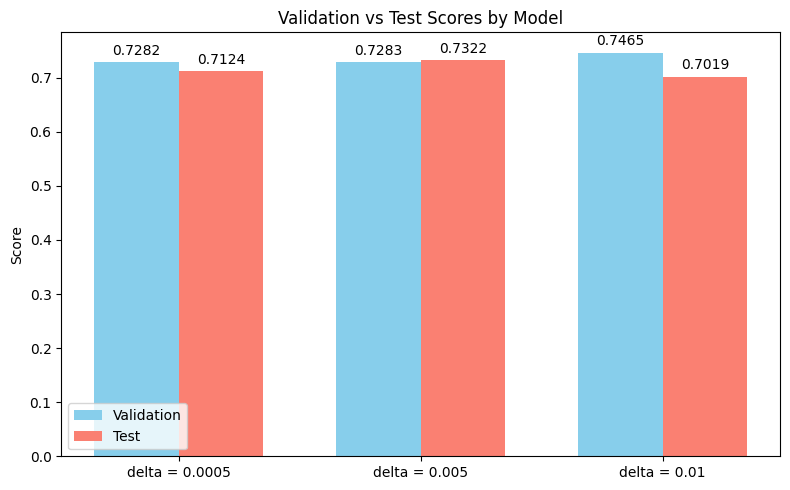

In [ ]:
history_filenames = ['saved_models/history_0005.json', 
                    'saved_models/history_005.json', 
                    'saved_models/history_01.json']

histories = [json.load(open(fname, 'r')) for fname in history_filenames]

validation_scores = [max(history['val_accuracy']) for history in histories]
test_scores = [test_accuracy_0005, test_accuracy_005, test_accuracy_01]

models = ['delta = 0.0005', 'delta = 0.005', 'delta = 0.01']

plot_val_and_loss(validation_scores, test_scores, models)
